### Demonstration of Gaussian Process Regression (GPR) with multiple-units time series data

The dataset we are going to use in this demo is the physical integrity rights index (PIRI) data, which comes from Strezhnev, Anton, Judith G Kelley and Beth A Simmons. 2021. “Testing for Negative Spillovers: Is Promoting Human Rights Really Part of the “Problem”?” International
Organization 75(1):71–102

#### Introduction

Gaussian Process Regression (GPR) is a Bayesian non-parameteric machine learning method for learning complex functional relation with uncertainty estimation. We will demonstrate in this tutorial how to apply GPR for Political Science research, and show how to estimate the marginal effects of the treatment *AIshame* and other covariates on *PIRI* under GPR framework. Readers who are not familiar with GPR are encouraged to read Chapter 2 of [Gaussian Processes for Machine Learning](https://gaussianprocess.org/gpml/chapters/RW2.pdf) for a complete introduction. In short, Gaussian process assumes the observations $\{y_i\}_{1}^n$ at input locations $\{x_i\}_{1}^n$ have a joint Gaussian distribution:
$$
[y_1,\dots,y_n]^T \sim \mathcal{N}(\mu,K)
$$
where the covariance matrix is determined by the kernel $K(x,x')$ so $K_{ij}=K(x_i,x_j)$. Notationwise, GPR can also be written as $f \sim \mathcal{GP}(\mu,K)$. Throughout this demonstration, we will use the RBF kernel (also known as the squared exponential kernel), specified by $K(x,x')=\rho^2 \exp(-\frac{(x-x')^2}{2\ell^2})$. Here $\rho^2$ is the output scale that controls the variance of deviation from the mean trend, and $\ell$ is the length scale that determines how fast two distanced input locations become less correlated. Both of them belong to the set of hyperparameters in GPR, and can either be handcoded based on prior knowledge or optimized based on [maximum-likelihood-ii](https://en.wikipedia.org/wiki/Empirical_Bayes_method).

There are many implemenations of GPR in R(GauPro, gausspr), python(gpytorch, scikit-learn) and matlab (gpml). This tutorial is done in the gpytorch, a highly efficient and modular implementation of GPs with GPU acceleration.

In [1]:
# load gpytoch and other packages
import torch
import numpy as np
import pandas as pd
import gpytorch
from scipy.stats import norm
from typing import Optional, Tuple
from matplotlib import pyplot as plt
from gpytorch.means import LinearMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.kernels import ScaleKernel, RBFKernel
from statsmodels.stats.stattools import durbin_watson

#### Load and setup data

In this cell, we set up the PIRI data for this example. The physical integrity rights index (PIRI) is a composite index of repression indices obtained by adding together the scores for the four physical integrity measures: killing, torture, imprisonment, and disappearances. This yields a variable that ranges from 0 (no violations on any of the four measures) to 8 (worst scores on all four measures). The treatment variable is *AIShame*, which indicates whether Amnesty International, an international human rights organization, publicly shames a country about their physical integrity rights. Other covariates include *CAT* and *CCPR* (Convention Against Torture and International Covenant on Civil and Political Rights), measures of economic development (pop and gdp) and national security (war and civil war). Following Strezhnev et al. 2021, we use *PIRILead1* as our DV (dependent variable).

In [2]:
def load_PIRI_data():
    # read data
    url = "https://raw.githubusercontent.com/yahoochen97/GP_gradient/main/hb_data_complete.csv"
    data = pd.read_csv(url, index_col=[0])

    # all zero PIRI for new zealand and netherland
    data = data.loc[~data['country'].isin(['N-ZEAL','NETHERL'])]

    countries = sorted(data.country.unique())
    years = data.year.unique()
    n = len(countries)
    m = len(years)

    # build data
    country_dict = dict(zip(countries, range(n)))
    year_dict = dict(zip(years, range(m)))

    # x is:
    # 1: year number
    # 2: country id
    # 3: AIShame (treatment indicator)
    # 4: cat_rat
    # 5: ccpr_rat
    # 6: democratic
    # 7: log(gdppc)
    # 8: log(pop)
    # 9: Civilwar2
    # 10: War
    x = torch.zeros(data.shape[0], 10)
    x[:,0] = torch.as_tensor(list(map(year_dict.get, data.year)))
    x[:,1] = torch.as_tensor(list(map(country_dict.get, data.country)))
    x[:,2] = torch.as_tensor(data.AIShame.to_numpy())
    x[:,3] = torch.as_tensor(data.cat_rat.to_numpy())
    x[:,4] = torch.as_tensor(data.ccpr_rat.to_numpy())
    x[:,5] = torch.as_tensor(data.democratic.to_numpy())
    x[:,6] = torch.as_tensor(data.log_gdppc.to_numpy())
    x[:,7] = torch.as_tensor(data.log_pop.to_numpy())
    x[:,8] = torch.as_tensor(data.Civilwar2.to_numpy())
    x[:,9] = torch.as_tensor(data.War.to_numpy())
    # x[:,10] = torch.as_tensor(data.PIRI.to_numpy())
    y = torch.as_tensor(data.PIRILead1.to_numpy()).double()

    unit_means = torch.zeros(n,)
    for i in range(n):
        unit_means[i] = y[x[:,1]==i].mean()

    return x.double(), y.double(), unit_means.double(), data, countries, years

train_x, train_y, unit_means, data, countries, years = load_PIRI_data()

#### How to interpret fixed effects model as GPR

Let's see how the baseline fixed effects model works. The fixed effects model regresses *PIRILead1* with the treatment and covariate variables dicussed above with year- and country- level fixed effects:
$$
\text{PIRILead1} \sim \text{AIShame}  + \text{democrat} + ... +  \text{C(year)} + \text{C(country)} + \varepsilon
$$
Mathematically it is equivalent to write DV $y_{it}$ in terms of IV $x_{it}$, slope $\beta$, time effects $\alpha_t$ and country effects $b_i$
$$
y_{it} \sim \beta^T x_{it} + \alpha_t + b_i + \varepsilon_{it}
$$

In [3]:
import statsmodels.formula.api as sm

lm = sm.ols('PIRILead1 ~ AIShame  + cat_rat + ccpr_rat \
            + democratic + log_gdppc + log_pop \
            + Civilwar2 + War + C(year) + C(country) + PIRI', data).fit()

coefs = lm.params.to_dict()
covariate_names = ["AIShame" ,"cat_rat" , "ccpr_rat",
           "democratic",  "log_gdppc", "log_pop",
            "Civilwar2", "War"]
x_weights = list(map(coefs.get, covariate_names))

A Bayesian alternative of this fixed effect model makes two additional prior assumptions. First, a Gaussian prior is put on the slope $\beta\sim\mathcal{N}(0,\Sigma_{\beta})$. Second, i.i.d. Gaussian priors are also placed on the fixed effects $\alpha_t\sim\mathcal{N}(0,\sigma^2_{t})$ and $b_i\sim\mathcal{N}(0,\sigma^2_{i})$ so as to be random effects. In this new Bayesian hierarchical model, we can now compute the corresponding mean and covariance between any two input triples $(x_{it},i,t)$ and $(x_{i't'},i',t')$
$$
\begin{gathered}
E[y_{it}] = E[\beta^T] x_{it} + E[\alpha_{t}] + E[b_{i}] + E[\varepsilon_{it}] = 0\\
\text{cov}[y_{it},y_{i't'}] = x_{it} \text{cov}[\beta^T,\beta^T] x_{i't'} + \text{cov}[\alpha_{t},\alpha_{t'}] + \text{cov}[b_{i},b_{i'}] = x_{it} \Sigma_{\beta} x_{i't'} + \mathbb{I}[t=t']\sigma^2_{t} + \mathbb{I}[i=i']\sigma^2_{i}
\end{gathered}
$$
where the indicator function $\mathbb{I}[i=i']$ is 1 iff the country indices are the same $i=i'$. Hence, we can see that the linear component $\beta^T x_{it}$ with normal prior on $\beta$ is equivalent to GPR with a so-called linear kernel, and the random effect is equivalent to GPR with an indicator kernel. This kernel trick also works with basis expansion $\phi(x_{it})$ such as quadratic terms or interactions, so by designs of kernels GPR can automatically perform feature selection instead of manual transformation. As is well known, the RBF kernel we are going to use corresponds to basis transformation to an infinite dimensional space.

#### Customization of mean and kernel

One good thing about gpytorch is its flexibility in customization of mean functions and covariance functions, although someone may argue such flexibility is bad for new users who are not used to coding. Therefore, we simply provide two customized mean functions: a constant mean $E[f(x,i,t)]=c_i$ that simply returns a predefined value dependent on index $i$ and a mask mean $E[f(x,i,t)]=E[f(x_{\text{mask}},i,t)]$ that ignores some dependent variables. The implementation is done by inheriting derived classes from base classes and customizing the functional relation in the `forward()` function, which should be familiar to pytorch users. Customization of kernels is slightly more complicated so we skip them in this demo, but advanced readers are welcome to check source codes from [gpytorch doc](https://docs.gpytorch.ai/en/stable/_modules/gpytorch/kernels/polynomial_kernel.html#PolynomialKernel).

In [4]:
class ConstantVectorMean(gpytorch.means.mean.Mean):
    def __init__(self, d=1, prior=None, batch_shape=torch.Size(), **kwargs):
        super().__init__()
        self.batch_shape = batch_shape
        self.register_parameter(name="constantvector",\
                 parameter=torch.nn.Parameter(torch.zeros(*batch_shape, d)))
        if prior is not None:
            self.register_prior("mean_prior", prior, "constantvector")

    def forward(self, input):
        return self.constantvector[input.int().reshape((-1,)).tolist()]
    
class MaskMean(gpytorch.means.mean.Mean):
    def __init__(
        self,
        base_mean: gpytorch.means.mean.Mean,
        active_dims: Optional[Tuple[int, ...]] = None,
        **kwargs,
    ):
        super().__init__()
        if active_dims is not None and not torch.is_tensor(active_dims):
            active_dims = torch.tensor(active_dims, dtype=torch.long)
        self.active_dims = active_dims
        self.base_mean = base_mean
    
    def forward(self, x, **params):
        return self.base_mean.forward(x.index_select(-1, self.active_dims), **params)

#### Build GPR model for multi-unit time-series data

GPR model is in general good for multi-unit time series data for two reasons. First, the use of kernel functions implicitly perform feature transformation and selection so social scientists could no longer worry about missing interaction or non-linearity. Secondly and maybe more importantly, many time series models other than simple fixed effects can be easily integrated into GPR framework. For example, the commonly used autoregression (AR) model is shown to be a Gaussian process with [a composite of kernels](http://herbsusmann.com/2019/08/09/autoregressive-processes-are-gaussian-processes/). For the purpose of illustration, we adopt the following specification of a country-level time trend plus covariate process for the PIRI dataset:
$$
\begin{gathered}
y_i(t) \sim u_i(t) + f(x_{it}) + \varepsilon \\
f(x_{it}) \sim GP(0, K_x) \\
u_i(t) \sim GP(b_i, K_t)
\end{gathered}
$$
where the time trends $u_i(t)$s are GPs with mean $b_i$s acting as country-level fixed effects and time kernel $K_t$ acting as time-level random effects but with temporal correlation, and the covariate process is zero-meaned and has kernel $K_x$.

The most critical part of GPR in gpytorch codewise is the model class, where both mean and covariance functions are defined. Shortly speaking, users need to define different mean and covariance modules based on their desired model in the `__init__()` function, and sum up those modules for both mean and covariance functions in the `forward()` function. Again, gpytorch website has a detailed walkthrough of [GPR regression](https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Simple_GP_Regression.html) for complete reference.

In [5]:
# model specification: PIRI gp model with unit trends
# x_it : AIShame + cat_rat + ccpr_rat 
#            + democratic + log(gdppc) + log(pop) 
#            + Civilwar2 + War 
# y_i(t) ~ u_i(t) + f(x_{it}) + ε
# f(x_{it}) ~ GP(0, K_x)
# u_i(t) ~ GP(b_i, K_t)

class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        # constant country-level mean
        self.mean_module = MaskMean(active_dims=1, \
               base_mean=ConstantVectorMean(d=train_x[:,1].unique().size()[0]))
        # linear mean for continuous covariates
        self.x_mean_module = MaskMean(active_dims=[2,3,4,5,6,7,8,9], base_mean=LinearMean(input_size=8, bias=False))
        # year kernel * country kernel
        self.unit_covar_module = ScaleKernel(RBFKernel(active_dims=0)*RBFKernel(active_dims=1))
        self.x_covar_module = torch.nn.ModuleList([ScaleKernel(RBFKernel(\
            active_dims=(i))) for i in [6,7]])
        # dummy mean for categorical covariates
        self.binary_covar_module = torch.nn.ModuleList([ScaleKernel(RBFKernel(\
            active_dims=(i))) for i in [3,4,5,8,9]])
        self.effect_covar_module = ScaleKernel(RBFKernel(active_dims=2))

    def forward(self, x):
        mean_x = self.mean_module(x) + self.x_mean_module(x)
        unit_covar_x = self.unit_covar_module(x)
        effect_covar_x = self.effect_covar_module(x)
        covar_x = unit_covar_x + effect_covar_x
        for i, _ in enumerate(self.x_covar_module):
            covar_x += self.x_covar_module[i](x)
        for i, _ in enumerate(self.binary_covar_module):
            covar_x += self.binary_covar_module[i](x)
        
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

#### Hyperparameter tuning and training of GPR model

As mentioned previously, GPR is usually associated with a set of hyperparameters either in the mean function (country-level intercept) or the kernel (length scale, output scale). These hypparameters could either be handcoded based on prior belief or be tuned by empirical bayes methods such as maximizing type-ii likelihood. Here we should how to perform MLE-II for GPR. We start by defining and initializing the GP model and likelihood:

In [6]:
likelihood = GaussianLikelihood()
model = GPModel(train_x, train_y, likelihood).double()

# initialize model parameters
hypers = {
    'mean_module.base_mean.constantvector': unit_means,
    'x_mean_module.base_mean.weights': torch.tensor(x_weights),
    'likelihood.noise_covar.noise': torch.tensor(0.25),
    'unit_covar_module.base_kernel.kernels.0.lengthscale': torch.tensor(6),
    'unit_covar_module.base_kernel.kernels.1.lengthscale': torch.tensor(0.01),
    'unit_covar_module.outputscale': torch.tensor(4),
    'x_covar_module.0.outputscale': torch.tensor(1),
    'x_covar_module.1.outputscale': torch.tensor(1),
    'binary_covar_module.0.base_kernel.lengthscale': torch.tensor(0.01),
    'binary_covar_module.1.base_kernel.lengthscale': torch.tensor(0.01),
    'binary_covar_module.2.base_kernel.lengthscale': torch.tensor(0.01),
    'binary_covar_module.3.base_kernel.lengthscale': torch.tensor(0.01),
    'binary_covar_module.4.base_kernel.lengthscale': torch.tensor(0.01),
    'binary_covar_module.0.outputscale': torch.tensor(1),
    'binary_covar_module.1.outputscale': torch.tensor(1),
    'binary_covar_module.2.outputscale': torch.tensor(1),
    'binary_covar_module.3.outputscale': torch.tensor(1),
    'binary_covar_module.4.outputscale': torch.tensor(1),
    'effect_covar_module.base_kernel.lengthscale': torch.tensor(0.01),
    'effect_covar_module.outputscale': torch.tensor(1)
}    

model = model.initialize(**hypers)

Similar to other machine learning algorithms, training of GPR means to find the optimal set of hyperparameters (or parameters in other ML algorithms) for some objective. For GPR with $f\sim\mathcal{GP}(0,K)$, the objective is to maximize the type-ii log likelihood
$$
\log(y\mid x) = -\frac{1}{2}y^T\big(K(x,x)+\sigma^2_{\text{noise}}\mathbf{I}\big)^{-1}y-\frac{1}{2}\log\Big(\det\big(K(x,x)+\sigma^2_{\text{noise}}\big)\Big)-\frac{n}{2}\log(2\pi)
$$
As gpytorch is built on the top of pytorch, optimization of this objective is very convenient using off-the-shelf optimizers such as [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html). Hyperparameters can also be fixed by simpling excluding them from the optimization procedure. For example, we have used RBF kernel as a shortcut for binary indicator kernel by fixing the length scale to be some small number ($0.01$ in our case), so $\text{cov}(0,1)=\exp(-1/2/0.01^2)\approx 0$.

In [7]:
# train model
model.train()
likelihood.train()

torch.manual_seed(12345)

# freeze length scale in the country component in unit covar
# freeze constant unit means
all_params = set(model.parameters())
final_params = list(all_params - \
            {model.unit_covar_module.base_kernel.kernels[1].raw_lengthscale, \
        #    model.unit_covar_module.raw_outputscale, \
        #    model.mean_module.base_mean.constantvector, \
        #    model.x_covar_module[0].raw_outputscale, 
        #    model.x_covar_module[1].raw_outputscale,
        #    model.likelihood.noise_covar.raw_noise,
            model.binary_covar_module[0].base_kernel.raw_lengthscale,
            model.binary_covar_module[1].base_kernel.raw_lengthscale,
            model.binary_covar_module[2].base_kernel.raw_lengthscale,
            model.binary_covar_module[3].base_kernel.raw_lengthscale,
            model.binary_covar_module[4].base_kernel.raw_lengthscale,
        #    model.binary_covar_module[0].raw_outputscale,
        #    model.binary_covar_module[1].raw_outputscale,
        #    model.binary_covar_module[2].raw_outputscale,
        #    model.binary_covar_module[3].raw_outputscale,
        #    model.binary_covar_module[4].raw_outputscale,
            model.effect_covar_module.base_kernel.raw_lengthscale})
        #    model.effect_covar_module.raw_outputscale})
optimizer = torch.optim.Adam(final_params, lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    if i % 10 == 0:
        print('Iter %d/%d - Loss: %.3f '  % (
            i , training_iter, loss.item()
        ))
    optimizer.step()

torch.save(model.state_dict(), "PIRI_GPR_model.pth")

/Users/yahoo/anaconda3/lib/python3.7/site-packages/gpytorch/functions/_pivoted_cholesky.py:118: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2189.)
  [L, torch.triangular_solve(Krows[..., m:, :].transpose(-1, -2), L, upper=False)[0].transpose(-1, -2)],


Iter 0/50 - Loss: 2.256 
Iter 10/50 - Loss: 1.740 
Iter 20/50 - Loss: 1.649 
Iter 30/50 - Loss: 1.610 
Iter 40/50 - Loss: 1.591 


#### Posterior of GPR model

After hyperparameter tuning, we now discuss how to derive posterior of GPR model. It is worth reminding that hyperparameter tuning is orthogonal to deriving GPR posterior, since the former only finds the set of hyperparameters that best explains the data apriori. Like any other Bayesian method, we still need to condition the GPR prior on observed data and derive its posterior to fully "learn" the model. Fortunately, GPR posterior looks extremely nice with Gaussian noise. Assuming $f\sim\mathcal{GP}(0,K)$ and we observed $\mathcal{D}=\{x,y\}$, the posterior $f\mid \mathcal{D}$ at any test location $x^*$ is
$$
\begin{gathered}
f(x^*)\mid \mathcal{D}\sim \mathcal{GP}(\mu_{f\mid \mathcal{D}},K_{f\mid \mathcal{D}})\\
\mu_{f\mid \mathcal{D}}(x^*) = K(x,x^*)\big(K(x,x)+\sigma^2_{\text{noise}}\mathbf{I}\big)^{-1}y\\
K_{f\mid \mathcal{D}}(x^*,x^*) = K(x^*,x^*) - K(x^*,x)\big(K(x,x)+\sigma^2_{\text{noise}}\mathbf{I}\big)^{-1}K(x,x^*)
\end{gathered}
$$
Fortunately, gpytorch has implemented the posterior update rule for us so we don't have to manually code them up. The RMSE loss of the fitted GPR model can be computed as:

In [8]:
# load the trained model
model.load_state_dict(torch.load('PIRI_GPR_model.pth'))

# set model and likelihood to evaluation mode, meaning that we are dealing with posterior now
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    out = model(train_x)
    mu_f = out.mean.numpy()
    lower, upper = out.confidence_region()

# store results
results = pd.DataFrame({"gpr_mean":mu_f})
results['true_y'] = train_y
results['gpr_lwr'] = lower
results['gpr_upr'] = upper
results['year'] = years[train_x[:,0].numpy().astype(int)]
results['country'] = [countries[i] for i in train_x[:,1].numpy().astype(int)]
results.to_csv("./results/PIRI_fitted_gpr.csv",index=False) #save to file

# print RMSE
RMSE = np.square((out.mean - train_y).detach().numpy()).mean()**0.5
print(RMSE)

/Users/yahoo/anaconda3/lib/python3.7/site-packages/gpytorch/models/exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


0.9374067306442194


Note that there is a default warning from gpytorch because gpytorch expects a test input tensor other than the training input tensor in posterior mode. However, we are exactly interested in the fitted values at training input locations by letting $x^*=x$. We are very aware that by calling `eval()` functions we are computing the posterior rather than the prior, so we do not need to call `train()` functions.

#### Effect estimation of binary treatment

Supervised machine learning algorithms are predictive models, meaning that they are interested in getting as close as possible to the ground truth for new unseen observations. On the contrary, social scientists are interested in the treatment effect on the targeted DV, assuming collected data well respresent the whole population. Using the potential outcome framework, the conditional treatment effect for a binary treatment is defined as
$$
\tau(x) = \mathbb{E}[y^{(1)}-y^{(0)}\mid x] \approx \mathbb{E}[y_{it}\mid x_{it}, D_{it}=1] - \mathbb{E}[y_{it}\mid x_{it}, D_{it}=0]
$$
In GPR, estimation of $\tau(x)$ is straight-forward as the model allows us to do inference on unobserved counterfactuals. Suppose we already have the posterior of a general model $f(z;x)\sim \mathcal{GP}(\mu,K)$ for the joint of treatment $z$ and covariate $x$ (we could append country and time indices $i,t$ to $x$), and we can get the posterior of $\tau(x)$ with MAP and also uncertainty estimation:
$$
{\tau}(x) = f(1;x) - f(0;x) \sim \mathcal{GP}\Big(\mu(1;x)-\mu(0;x),K([1;x],[1;x])+K([0;x],[0;x])\Big)
$$

In [9]:
model.load_state_dict(torch.load('PIRI_GPR_model.pth'))

model.eval()
likelihood.eval()

# copy training tesnor to test tensors and set AIshame to 1 and 0
test_x1 = train_x.clone().detach().requires_grad_(False)
test_x1[:,2] = 1
test_x0 = train_x.clone().detach().requires_grad_(False)
test_x0[:,2] = 0

# in eval mode the forward() function returns posterioir
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    out1 = likelihood(model(test_x1))
    out0 = likelihood(model(test_x0))

# compute ATE and its uncertainty
effect = out1.mean.numpy().mean() - out0.mean.numpy().mean()
effect_std = np.sqrt((out1.mean.numpy().mean()+out0.mean.numpy().mean())) / np.sqrt(train_x.size()[0])
BIC = (2+4+6+1)*torch.log(torch.tensor(train_x.size()[0])) + 2*loss*train_x.size()[0]
print("ATE: {:0.3f} +- {:0.3f}\n".format(effect, effect_std))
print("model evidence: {:0.3f} \n".format(-loss*train_x.size()[0]))
print("BIC: {:0.3f} \n".format(BIC))

ATE: 0.063 +- 0.054

model evidence: -3372.634 

BIC: 6844.941 



#### Sensitivity analysis for autocorrelation

One argument we make is that GPR is powerful in building flexible, but structured, models in the presence of clustering and spatio-temporal autocorrelation. For PIRI application, the unobserved time shocks on each country are modeled by GPR with consideration of temporal autocorrelation. We now test this hypothesis by perform Durbin Watson autocorrelation tests for fitted GPR residuals.

In [10]:
model.load_state_dict(torch.load('PIRI_GPR_model.pth'))

model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    out = likelihood(model(train_x))
    mu_f = out.mean.numpy()

# DW-test for sample size = 18 (years) and 8 regressors.
dL = 0.407
dU = 2.668
n = len(countries)
DW_results = np.zeros((n,))
for i in range(n):
    mask = data.country==countries[i]
    mask = mask.to_list()
    res = train_y[mask] - mu_f[mask] # post_unit_mean[mask]
    DW_results[i] = durbin_watson(res.detach().numpy())

print("{} out of {} residuals are positively correlated.\n".format(np.sum(DW_results<=dL),n))
print("{} out of {} residuals are negatively correlated.\n".format(np.sum(DW_results>=dU),n))
print("{} out of {} residuals are not correlated.\n".format(np.sum((DW_results>dL) & (DW_results<dU)),n))
    

0 out of 138 residuals are positively correlated.

17 out of 138 residuals are negatively correlated.

121 out of 138 residuals are not correlated.



We can see that for the majority of countries the residuals are not correlated temporally. Hence, GPR better meets the exogeneity assumption than fixed effects by adjusting for temporal correlated unobserved confoundings. 

#### Estimation of marginal effects for covariates
Another quantity of interests to social scientists is the averaged marginal effect of covariate variables, which describles on average how change in covariates reflects change in targeted DV. The causal effect of a continuous treatment can also be understood as a certain type of marginal effect, as we can no longer compute the difference in means. For linear regression model, the marginal effects are simply the slopes in front of covariate variables, or the gradients of those variables on DV. Similarly, we can compute the corresponding marginal effects in GPR framework using differentiation of GPR. Luckily, differentiation is a linear operator and by the closure property of Gaussian process under linear transformation, we have a multivariate Gaussian for the joint of $f$ and $\nabla f$
$$
\begin{bmatrix}
    \mathbf{f}\\
    \nabla \mathbf{f}
\end{bmatrix}
\sim
\mathcal{GP} \begin{bmatrix}
\mu_{\mathbf{f}} \\
\nabla \mu_{\mathbf{f}} 
 \end{bmatrix}
, \begin{bmatrix}
    \mathbf{K}_{f} &\nabla \mathbf{K}_{f }^T\\
    \nabla \mathbf{K}_{f} & \nabla^2\mathbf{K}_{f}
\end{bmatrix}
$$
and we can derive the posterior of $\nabla f$ by conditioning on observation of $f$
$$
\begin{gathered}
 \nabla {f} \mid \mathcal{D}\sim \mathcal{GP}(\mu_{\nabla f\mid \mathcal{D}},K_{\nabla f\mid \mathcal{D}})\\
\nabla\mu_{f\mid \mathcal{D}}(x^*) = \nabla K_{f\mid \mathcal{D}}(x,x^*)\big(\nabla^2 K_{f\mid \mathcal{D}}(x,x)+\sigma^2_{\text{noise}}\mathbf{I}\big)^{-1}y\\
\nabla K_{f\mid \mathcal{D}}(x^*,x^*) = \nabla^2 K_{f\mid \mathcal{D}}(x^*,x^*) - \nabla K_{f\mid \mathcal{D}}(x^*,x)\big(\nabla^2 K_{f\mid \mathcal{D}}(x,x)+\sigma^2_{\text{noise}}\mathbf{I}\big)^{-1} \nabla K_{f\mid \mathcal{D}}(x,x^*)
\end{gathered}
$$
Unfortunately, the above posterior has not been implemented by gpytorch yet (they have been working on it but the changes may have not been pushed to latest verision). However, pytorch is known for its fast gradient computation via autogradient, which we are going to exploit. Specifically, we are going to sample from posterior of the function, use `torch.auto.grad` to compute their gradients and estimate the standard deviation using the empirical means and gradients. 

In [11]:
model.load_state_dict(torch.load('PIRI_GPR_model.pth'))

model.eval()
likelihood.eval()

df_std = np.zeros((train_x.size(0),train_x.size(1)))
x_grad = np.zeros((train_x.size(0),train_x.size(1)))

# number of empirically sample 
n_samples = 100
sampled_dydtest_x = np.zeros((n_samples, train_x.size(0),train_x.size(1)))

# we proceed in small batches of size 100 for speed up
for i in range(train_x.size(0)//100):
    with gpytorch.settings.fast_pred_var():
        test_x = train_x[(i*100):(i*100+100)].clone().detach().requires_grad_(True)
        observed_pred = likelihood(model(test_x))
        dydtest_x = torch.autograd.grad(observed_pred.mean.sum(), test_x, retain_graph=True)[0]
        x_grad[(i*100):(i*100+100)] = dydtest_x
        loss = mll(observed_pred, train_y[(i*100):(i*100+100)])

        sampled_pred = observed_pred.rsample(torch.Size([n_samples]))
        sampled_dydtest_x[:,(i*100):(i*100+100),:] = torch.stack([torch.autograd.grad(pred.sum(), \
                                    test_x, retain_graph=True)[0] for pred in sampled_pred])
        
# last 100 rows
with gpytorch.settings.fast_pred_var():
    test_x = train_x[(100*i+100):].clone().detach().requires_grad_(True)
    observed_pred = likelihood(model(test_x))
    dydtest_x = torch.autograd.grad(observed_pred.mean.sum(), test_x, retain_graph=True)[0]
    x_grad[(100*i+100):] = dydtest_x
    loss = mll(observed_pred, train_y[(100*i+100):])

    sampled_pred = observed_pred.rsample(torch.Size([n_samples]))
    sampled_dydtest_x[:,(100*i+100):,:] = torch.stack([torch.autograd.grad(pred.sum(),\
                                     test_x, retain_graph=True)[0] for pred in sampled_pred])
    

With samples from the gradients, we can estimate the marginal effects of all regressors by adding the variance of the gradient means and the mean of the gradient variances.

In [12]:
est_std = np.sqrt(sampled_dydtest_x.mean(1).std(0)**2 + \
                  sampled_dydtest_x.std(1).mean(0)**2).round(decimals=5)

results = pd.DataFrame({"x": covariate_names, \
                        'est_mean': x_grad.mean(axis=0)[2:10],
                        'est_std': est_std[2:10]})
results["t"] = results['est_mean'].values/results['est_std'].values
results["pvalue"] = 1 - norm.cdf(np.abs(results["t"].values))
print(results)

            x  est_mean  est_std         t    pvalue
0     AIShame  0.024520  0.00000       inf  0.000000
1     cat_rat  0.034739  0.00000       inf  0.000000
2    ccpr_rat  0.331899  0.00000       inf  0.000000
3  democratic -0.623537  0.00000      -inf  0.000000
4   log_gdppc  0.019615  0.10183  0.192623  0.423627
5     log_pop  0.024292  0.01267  1.917308  0.027599
6   Civilwar2  0.629372  0.00000       inf  0.000000
7         War  0.354058  0.00000       inf  0.000000


/Users/yahoo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


We could also plot visualize the relation between the function versus covariates.

In [13]:
def plot_x(x_idx=2, x_range=torch.linspace(-1.7,2.1,101),x_name="Accountability"):
    model.load_state_dict(torch.load('PIRI_GPR_model.pth'))

    model.eval()
    likelihood.eval()

    N = x_range.shape[0]
    mu_f = np.zeros((train_x.size(0), N))
    lower_f = np.zeros((train_x.size(0), N))
    upper_f = np.zeros((train_x.size(0), N))
    for j in range(train_x.size(0)):
        test_x = train_x[0:N].clone().detach().requires_grad_(False)
        for i in range(N):
            test_x[i] = train_x[j].clone().detach().requires_grad_(True)
        test_x[:,x_idx] = x_range

        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            out = model(test_x)
            mu_f[j] = out.mean.numpy()
            lower, upper = out.confidence_region()
            lower_f[j] = lower.numpy()
            upper_f[j] = upper.numpy()

    plt.plot(test_x[:,x_idx].detach().numpy(), mu_f.mean(0))
    plt.plot(test_x[:,x_idx].detach().numpy(), lower_f.mean(0), '--')
    plt.plot(test_x[:,x_idx].detach().numpy(), upper_f.mean(0), '--')
    plt.xlabel(x_name)
    
    return mu_f.mean(0), lower_f.mean(0), upper_f.mean(0)

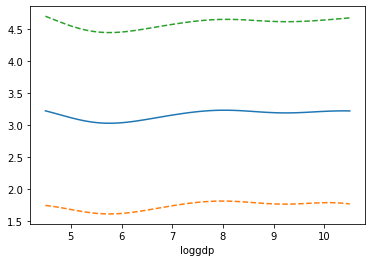

In [14]:
mu_gdp, lower_gdp, upper_gdp = plot_x(x_idx=6, x_range=torch.linspace(4.5,10.5,101),x_name="loggdp")

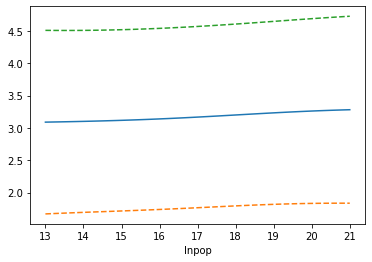

In [15]:
mu_pop, lower_pop, upper_pop = plot_x(x_idx=7, x_range=torch.linspace(13,21,101),x_name="lnpop")

In [16]:
results = pd.DataFrame({"gpr_mean":mu_gdp})
results['gpr_lwr'] = lower_gdp
results['gpr_upr'] = upper_gdp
results['cov_x'] = np.linspace(4.5,10.5,101)
results['cov_name'] = "loggdp"

results1 = pd.DataFrame({"gpr_mean":mu_pop})
results1['gpr_lwr'] = lower_pop
results1['gpr_upr'] = upper_pop
results1['cov_x'] = np.linspace(13,21,101)
results1['cov_name'] = "lnpop"
results = pd.concat([results, results1])

results.to_csv("./results/PIRI_pred_gpr.csv",index=False) #save to file